# Delo z robotom

1. Odprite **Franka Desk**:
   - Prvi robot: [10.20.0.23](https://10.20.0.23/desk/) 
   - Drugi robot: [10.20.0.24](https://10.20.0.24/desk/) 
2. Uporabniško ime in geslo dobite pri mentorju.

3. Preverite, da je varnostna gobica v aktivnem položaju.

4. Sprostite zavore:

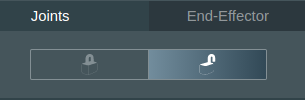

Aktivirarjte vmesnik FCI (Franka Control Interface).

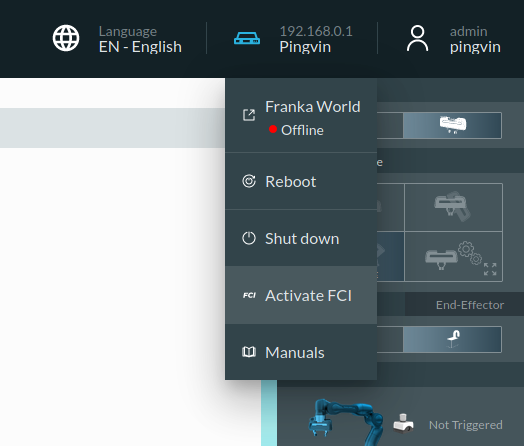

5. V meniju Operations izberite *Execution*. način *Programming* se uporablja za učenje prek demonstracije (angl. *programming by demonstration*).

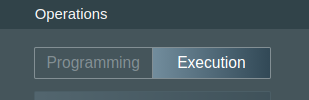

6. Preverite, ali lučka LED na robotu sveti zeleno, je varnostni scenarij nastavljen na Delo in je FCI VKLOPLJEN.

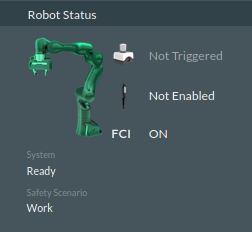

# Zagon glavnega ROS vozlišča

Odpri terminal:
```
docker restart rosmaster
```

In [ ]:
#TODO: ros master postavi kar na bambus
#TODO: nastavi isti namespace?

# Zagon kontrolerja

Odpri nov zavihek/razdelek v terminalu. 

Za prvega robota:
```
ssh pingvin@10.20.0.23 docker restart hri-vaje-controller
```

Za drugega robota:
```
ssh pingvin@10.20.0.24 docker restart hri-vaje-controller
```

Ta korak mora biti izveden po vsakem ponovnem zagonu rosmaster-ja.

# Premikanje robota s pomočjo knjižnice Robotblockset Python

In [ ]:
import rospy

In [ ]:
ns = "pingvin_2"

In [ ]:
rospy.init_node(ns)

In [ ]:
from robotblockset.ros.franka import panda_ros

In [ ]:
r = panda_ros(ns=ns, control_strategy="JointImpedance", init_node=False)

Preverite ali je robot v pravilnem načinu delovanja. 

In [ ]:
r.state.robot_mode == r.state.ROBOT_MODE_MOVE

Če ni, uporabite naslednji ukaz: `r.ErrorRecovery()`

In [ ]:
r.CMoveFor([0,0,0.1], 3)

In [ ]:
r.q

Kopijo izvorne kode knjižnice robotblockset najdete v mapi:

```
/home/vaje/rbs-docker/robotblockset_python/robotblockset/
```

*Opomba: Ker gre za kopijo, morebitne spremembe ne bodo vplivale na delovanje vaših programov!*

Pregledovalnik datotek najdete v meniju pod imenom **Dolphin (File manager)**.

Deklaracijo funkcij lahko preverite s pomočjo:

In [ ]:
import inspect
sig = inspect.signature(r.CMove)
print(sig)

In [ ]:
r.JMoveFor([0.2,0,0,0,0,0,0],3)

## Delo z robotsko prijemalko

In [ ]:
from robotblockset.ros.grippers_ros import PandaGripper
g = PandaGripper(namespace=ns,robot=r)

In [ ]:
g.Close()

In [ ]:
g.Open()

# Vizualizacija robota

Odpri nov zavihek **znotraj okolja Jupyter** in zaženi terminal. V terminalu poženi `rviz`.

*Opomba: V primeru uporabe sistemskega terminala je potrebno pognati `docker exec -it <ime aktivnega vsebnika s sliko rbs_docker> rviz`*

- V predelu Displays nastavi Fixed frame na pingvin_2_link0 (oz. pingvin_1_link0)
- Na dnu z gumbom Add dodaj RobotModel in Robot Description spremeni na pingvin_2/robot_description (oz. ustrezo za pingvin_1)
- Dodaj WrenchStamped in pod Topic nastavi /pingvin_2/franka_state_controller/F_ext (oz. ustrezno za pingvin_1)

## Kinestetično vodenje robota

In [ ]:
r.SetJointCompliant() # Ojačanja v kontrolerju nastavi na 0, robot bo kompenziral le gravitacijo

# Postopno višanje togosti robota.


**Pozor!** 

Pred nadaljnim programskim premikanjem je potrebno robota narediti nazaj togega. V praksi ne želimo prevelikih skokov kontrolnih signalov, zato bomo togost povečevali postopno.

Funkcijo se uporablja na sledči način. Posvetujte se z asistentom, kaj je lahko tu problem (če še niste govorili o tem).

In [ ]:
from utils import SoftSetJointCompliance
r.ResetCurrentTarget()
SoftSetJointCompliance(r,r._franka_default.JointCompliance.K,4)

# Spremljanje sklepnih koordinat na interaktivnem grafikonu

V terminalu znotraj tega okolja, poženi `rqt`.

- Plugins → Visualization
- V polje Topic vpiši: /pingvin_2/franka_state_controller/joint_states/position[0] in klikni + in tako naprej do [6]

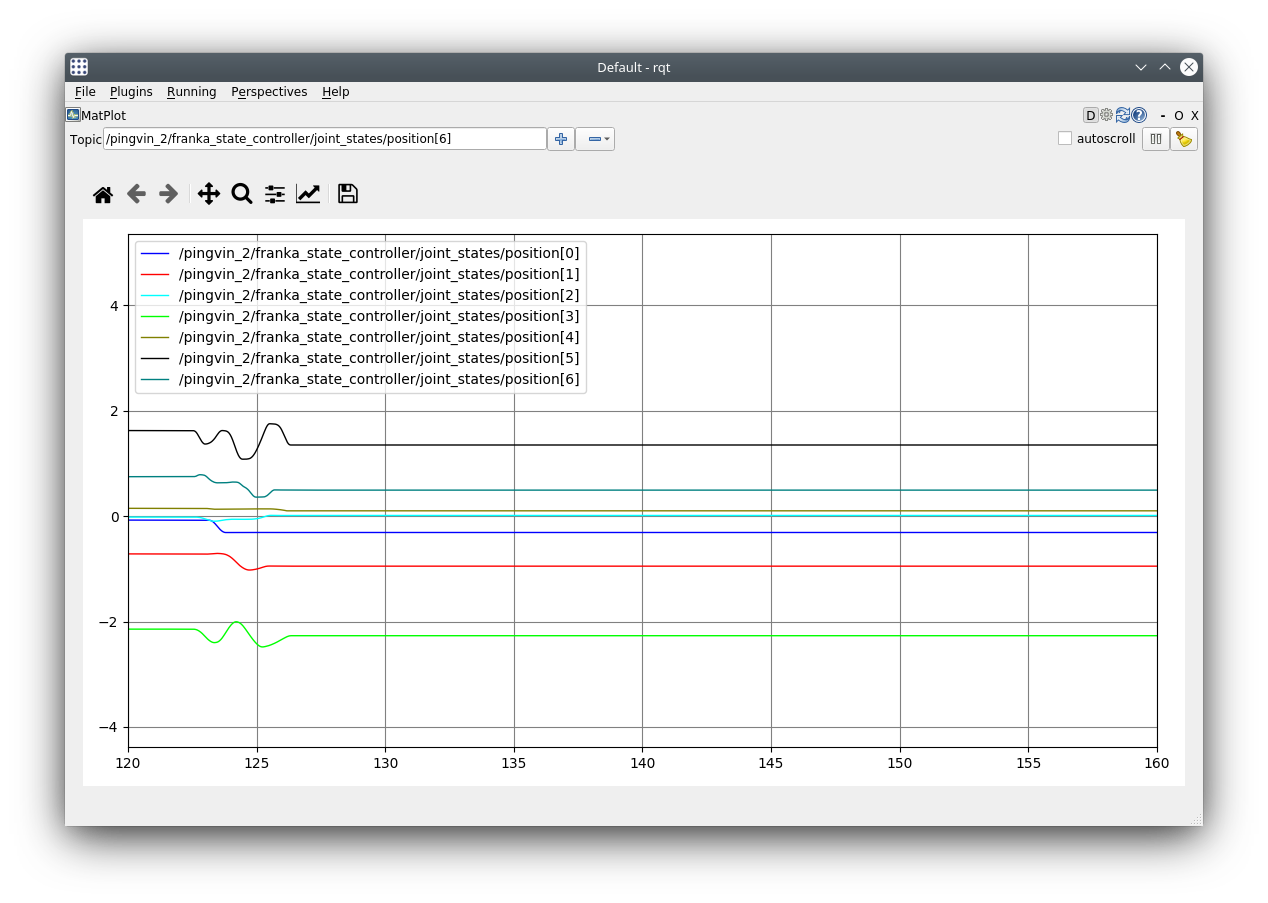

Premikaj robota in opazuj spreminjanje vrednosti kotov v sklepih.

# Spremljanje sil

Na podoben način lahko spremljamo tudi oceno sil na vrhu robota. Izračunane so iz merjenih vrednosti navorov v posameznih sklepih. Najprej bomo poiskali naslov ustrezne ROS temo, kamor se objavljajo te podatki.

In [ ]:
!rostopic list | grep F_ext

Oglejmo si strukturo sporočil:

In [ ]:
!rostopic echo -n 1 /pingvin_2/franka_state_controller/F_ext

Podatki o sili so zapisani v oseh v strukturi `wrench/forces`.

V nov graf dodaj `/pingvin_2/franka_state_controller/F_ext/wrench/force/x` (enako za: y in z)

# Snemanje

### Prek ROS-a

In [ ]:
!rosbag record /pingvin_2/franka_state_controller/joint_states

*Opomba: S pomočjo rosbag play se lahko ponovno predvaja nek topic npr. ko robot ni prižgan. Koristno npr. za snemanje rviz vizualizacije.*

### Prek RBS

 Pri vaji bomo želeli te podatke tudi obdelovati, zato je bolj priročno da uporabimo orodja v programskem okolju Robot Blockset (RBS).

Commands to query robot state:

```
r.p .... position
r.R .... orientation (as matrix)
r.Q .... orientation (as quaternion)

r.x ..... position + quaternion
r.T ..... 4x4 transformation matrix (position + orientation)

r.q .... robot joint angles
r.dq .... robot joint velocities
```


In [ ]:
from importlib import reload
import example_data_recorder
reload(example_data_recorder)

In [ ]:
r.ErrorRecovery()

In [ ]:
r._semaphore.release()

In [ ]:
import time
from robotblockset.transformations import rot_x, rp2t, q2r
from robotblockset.robots import isrobot
from robotblockset.graphics import plotjtraj, plotctraj
import matplotlib.pyplot as plt
import numpy as np

# Primer strukture za shranjevanje stanja robota se nahaja v datoteki example_data_recorder.py
from example_data_recorder import RobotDataRecorder

# Nastavimo parametre za snemanje in iniciliziramo medpomnilnik
recorder = RobotDataRecorder(r,max_iterations=5000)
r.SetCaptureCallback(recorder.record_callback)

# Definramo želeno lego
p0 = [0.5, 0, 0.5]
R0 = q2r(rot_x(np.pi))
T0 = rp2t(R0,p0)

r.ResetCurrentTarget() # Nastavi referenčno konfiguracijo na trenutno stanje  
r.ErrorRecovery() # Poskrbimo, da je robot v pravilnem stanju
r.SetJointStiff() # Nastavi ojačanja v kontrolerju

In [ ]:
# Zaženemo snemanje
r.SetJointStiff()
r.StartCapture()
# Sprožimo premik - POZOR, robot se bo premaknil!
r.CMove(T0, 5)
# Končamo snemanje
r.StopCapture()

In [ ]:
sig = inspect.signature(plotjtraj)
print(sig)

In [ ]:
# Prikaz na grafu, polne črte so dejansko, črtkane pa želeno stanje

last_entry=recorder.it

fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle("Joint trajectories")
plotjtraj(recorder.tt[:last_entry], recorder.qt[:last_entry], recorder.qdt[:last_entry], ax=ax)
plotjtraj(recorder.tt[:last_entry], recorder.rqt[:last_entry], recorder.rqdt[:last_entry], ax=ax, linestyle="--")

fig, ax = plt.subplots(3, 2, figsize=(9, 6))
fig.suptitle("Cartesiean trajectories")
plotctraj(recorder.tt[:last_entry], recorder.xt[:last_entry], recorder.vt[:last_entry], ax=ax)
plotctraj(recorder.tt[:last_entry], recorder.rxt[:last_entry], recorder.rvt[:last_entry], ax=ax, linestyle="--")

plt.show()

*Opomba: Zgornji način je uporaben za primerjavo dejanske izvedbe in želene izvedbe. Ko poženemo metodo StartCapture, se bo pri vsakem klicu metode GetState izvedla funkcija navedena s pomočjo SetCaptureCallback dokler snemanja ne prekinemo s pomočjo StopCapture. V našem primeru funkcijo GetState v ozadju kliče metoda CMove.*

***Pri kinestetičnem vodenju robota, pa to ne velja. Spodaj je primer funkcije za snemanje gibanja robota (vzorčimo pri 100 Hz)***

In [ ]:
import time
import numpy as np
def record_robot_state(robot, frequency, duration):
    interval = 1.0 / frequency
    
    N=int(frequency*duration)
    tt = np.zeros((N,1))
    qt = np.zeros((N,r.nj))
    dqt = np.zeros((N,r.nj))

    i = 0
    start_time = time.monotonic()
    end_time = start_time + duration
    
    last_update = time.monotonic()

    while time.monotonic() <= end_time+interval and i < N:
        t = time.monotonic()
        if t - last_update >= interval:
            
            # Get robot state
            state = robot.GetState()
            
            tt[i] = t-start_time
            qt[i] = r.q
            dqt[i] = r.qdot

            # Update the last recorded time
            last_update = t
            i += 1
        
    return tt, qt, dqt, i, N    

In [ ]:
#Robot naj bo podajen
r.SetJointCompliant()

In [ ]:
from utils import pip

time.sleep(1)
pip();
# vzorčimo 3 sekunde pri 100Hz
tt, qt, dqt, i, N = record_robot_state(r,100,3)
pip();

In [ ]:
print("Prvi element seznama pozicij sklepov", qt[0])
print("Prvi element seznama hitrosti sklepov", dqt[0])
print("Prvi element seznama časovnih razlik", np.diff(tt, axis=0)[0,0])
print("Približna Frekvenca vzorčenja (ekstrapolirano)", 1/np.diff(tt, axis=0)[0,0])

In [ ]:
from robotblockset.graphics import plotjtraj
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 1, figsize=(9, 6))
fig.suptitle('Joint trajectories')
plotjtraj(tt, qt, dqt, ax=ax);
plotjtraj(tt, qt+0.01, dqt, ax=ax, linestyle="--");

In [ ]:
# Move slowly to the first configuration
r.JMove(qt[0],5)
pip();
N=np.size(qt,0)
for q, qdot, tm in zip(qt, dqt, np.diff(tt, axis=0)): 
    # Call the GoTo_q function
    r.GoTo_q(q,qdot,np.zeros(7),0)
    # time.sleep(1/100.)
    time.sleep(tm[0])